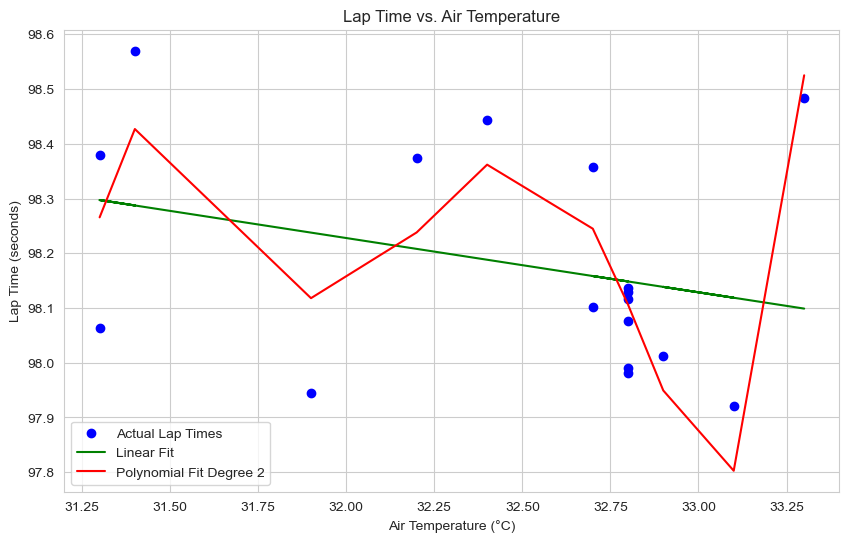

In [30]:
from scipy.stats import zscore
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('SAI_2018_Bahrain Grand Prix_data.csv', low_memory=False)


# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original Driver and Circuit for EDA
df['Original_Driver'] = df['Driver']

# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


#Feature Engineering with weather condition features
df['TrackConditionIndex'] = (df['AirTemp'] + df['TrackTemp'] + df['Humidity'] + df['Pressure'] +
                             df['WindSpeed'] + df['Rainfall']) / 6

# Tyre Age Interaction with TrackTemp 
df['TyreAge_TrackTemp'] = df['TyreLife'] * df['TrackTemp']

df['Temp_Rainfall_Interaction'] = df['TrackTemp'] * df['Rainfall']

# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus'])

# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time']
df.drop(columns=columns_to_drop, inplace=True)


# Select numerical values for scaling and imputation
numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','TrackConditionIndex','TyreAge_TrackTemp','Rainfall','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']


# Use IterativeImputer for more sophisticated imputation method
iterative_imputer = IterativeImputer(random_state=42)
df[numeric_features] = iterative_imputer.fit_transform(df[numeric_features])


## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method that effective to removes extreme outliers
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry


from scipy import stats

# Calculate Z-scores of `LapTime`
z_scores = stats.zscore(df_dry['LapTime'])
abs_z_scores = np.abs(z_scores)

# Filter data based on z-score
filtered_entries = (abs_z_scores < 0.217)
df_dry_filtered = df_dry[filtered_entries]




import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import operator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Ensure data types are correct and drop NaNs
df_filtered = df_dry_filtered[['LapTime', 'TrackTemp']].dropna()

# Prepare data for linear fit
X_lin = df_filtered[['TrackTemp']].values.reshape(-1, 1)
y_lin = df_filtered['LapTime'].values

# Linear regression
model_lin = LinearRegression()
model_lin.fit(X_lin, y_lin)
y_pred_lin = model_lin.predict(X_lin)

# Prepare data for polynomial fit
polynomial_features = PolynomialFeatures(degree=6)  # Adjust the degree based on visualization needs
X_poly = polynomial_features.fit_transform(X_lin)
model_poly = LinearRegression()
model_poly.fit(X_poly, y_lin)
y_pred_poly = model_poly.predict(X_poly)

# Sorting data for plotting
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_lin, y_pred_poly), key=sort_axis)
X_poly, y_poly = zip(*sorted_zip)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_lin, y_lin, color='blue', label='Actual Lap Times')
plt.plot(X_lin, y_pred_lin, color='green', label='Linear Fit')
plt.plot(X_poly, y_poly, color='red', label='Polynomial Fit Degree 2')
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Time vs. Air Temperature')
plt.legend()
plt.grid(True)
plt.show()


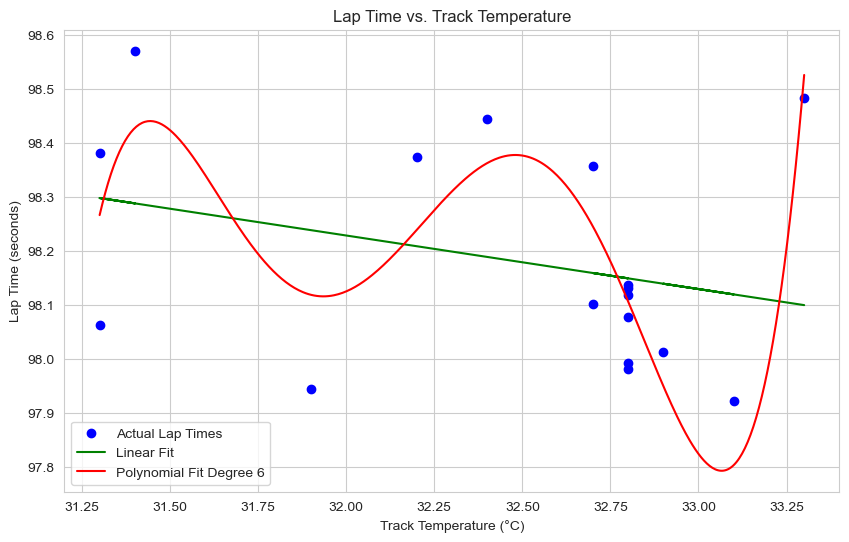

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Example data points (replace with your actual data)
X = df_dry_filtered[['TrackTemp']].values.reshape(-1, 1)
y = df_dry_filtered['LapTime'].values

# Linear regression
model_lin = LinearRegression()
model_lin.fit(X, y)
y_pred_lin = model_lin.predict(X)

# Polynomial regression with a smoother curve
degree = 6  # Adjust degree as needed
polynomial_features = PolynomialFeatures(degree=degree)
X_poly = polynomial_features.fit_transform(X)
model_poly = LinearRegression()
model_poly.fit(X_poly, y)

# Generating a dense grid for a smoother plot
X_fit = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)  # 500 points for smoothness
X_fit_poly = polynomial_features.transform(X_fit)
y_pred_poly = model_poly.predict(X_fit_poly)

# Sorting data for plotting (not necessary here since X_fit is already sorted)
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(X_fit, y_pred_poly), key=sort_axis)
X_poly_plot, y_poly_plot = zip(*sorted_zip)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Lap Times')  # Original data points
plt.plot(X, y_pred_lin, color='green', label='Linear Fit')  # Linear fit
plt.plot(X_fit, y_pred_poly, color='red', label='Polynomial Fit Degree ' + str(degree))  # Smooth polynomial curve
plt.xlabel('Track Temperature (°C)')
plt.ylabel('Lap Time (seconds)')
plt.title('Lap Time vs. Track Temperature')
plt.legend()
plt.grid(True)
plt.show()
